## Computing CO cross section using HITEMP
and covert to petitRadtran form

This tutorial demonstrates how to compute the opacity of CO using HITEMP step by step.

In [1]:
from exojax.spec import xsection
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import moldb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


First of all, set a wavenumber bin in the unit of wavenumber (cm-1).
Here we set the wavenumber range as $1000 \le \nu \le 10000$ (1/cm) with the resolution of 0.01 (1/cm). 

We call moldb instance with the path of par file.
If the par file does not exist, moldb will try to download it from HITRAN website.

In [2]:
# Setting wavenumber bins and loading HITRAN database
#nus=np.linspace(1000.0,10000.0,900000,dtype=np.float64) #cm-1
ne=1.e8/22500.0
ns=1.e8/24500.0
nus=np.linspace(ns,ne,40000,dtype=np.float64)
mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2019.par',nus)

Define molecular weight of CO ($\sim 12+16=28$), temperature (K), and pressure (bar).
Also, we here assume the 100 % CO atmosphere, i.e. the partial pressure = pressure.  

In [3]:
outdir="/home/kawahara/petitRADTRANS/petitRADTRANS/input_data/opacities/lines/line_by_line/COej_HITEMP19/"
np.array(1.0/nus[::-1],dtype=np.float64).tofile(outdir+"wlen.dat")
Mmol=28.010446441149536 # molecular weight

Tarr=np.logspace(2,3.5,10)
Parr=np.logspace(-10,2,13)
nu0=mdbCO.nu_lines

f=open(outdir+"PTpaths.ls","w")
for Tfix in Tarr:
    qt=mdbCO.Qr_line(Tfix)
    sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)
    for Pfix in Parr:
        Ppart=Pfix #partial pressure of CO. here we assume a 100% CO atmosphere. 

        Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
        gammaL = gamma_hitran(Pfix,Tfix, Ppart, mdbCO.n_air, \
                      mdbCO.gamma_air, mdbCO.gamma_self) + gamma_natural(mdbCO.A) 
        # thermal doppler sigma
        xsv=xsection(nus,nu0,sigmaD,gammaL,Sij,memory_size=30)
        Pval="{:.6f}".format(Pfix)
        P=str(Pval)+"bar"
        out="sigma_05_"+str(Tfix)+".K_"+P+".dat"
        f.write(str(Pval)+" "+str(Tfix)+" "+out+"\n")    
        op=np.array(xsv[::-1],dtype=np.float64)/(Mmol*1.66053892e-24)
        op.tofile(outdir+out)
f.close()

100%|██████████| 205/205 [00:02<00:00, 92.76it/s]


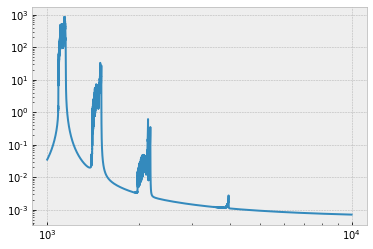

In [30]:
plt.plot(1.e7/nus,op)
plt.yscale("log")
plt.xscale("log")

In [20]:
Parr

array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [34]:
1/nu0[::-1]

array([0.00011814, 0.00011814, 0.00011814, ..., 0.00055869, 0.00056027,
       0.00056188])

In [35]:
nu0

array([1779.7496  , 1784.8403  , 1789.9077  , ..., 8464.751378,
       8464.86859 , 8464.881965])